In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new")

import matplotlib.pyplot as plt
from lib.plotting import adjust_plot_1d

In [30]:
bp = '/home/storage/hans/jax_reco_new/examples/'

MPE_sigma2 = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho_1st_pulse_MPE_tsigma_2.0.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho_1st_pulse_MPE_tsigma_2.0.npy'))])

MPE_sigma3 = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho_1st_pulse_MPE.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho_1st_pulse_MPE.npy'))])

MPE_sigma4 = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho_1st_pulse_MPE_tsigma_4.0.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho_1st_pulse_MPE_tsigma_4.0.npy'))])

MPE_sigma2_rho = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho2_1st_pulse_MPE_tsigma_2.0_clip_charge.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho2_1st_pulse_MPE_tsigma_2.0_clip_charge.npy'))])

#MPE_sigma2_rho = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho2_1st_pulse_MPE_tsigma_2.0_clip_charge_dyn.npy')), 
#                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho2_1st_pulse_MPE_tsigma_2.0_clip_charge_dyn.npy'))])

In [31]:
SPE_sigma2 = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho_1st_pulse_tsigma_2.0.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho_1st_pulse_tsigma_2.0.npy'))])

SPE_sigma3 = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho_1st_pulse.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho_1st_pulse.npy'))])

SPE_sigma2_rho = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho2_1st_pulse_tsigma_2.0.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho2_1st_pulse_tsigma_2.0.npy'))])

In [32]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [33]:
def get_gcd(results):
    scale = 20.0
    reco_zenith, reco_azimuth = results[:, 14]/scale, results[:, 15]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
    gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))
    muon_energy = results[:, 0]
    return gcd, gcd_smpe, muon_energy

In [34]:
def get_deltalogl(results):
    muon_energy = results[:, 0]
    delta_logl = results[:, -1]
    return muon_energy, delta_logl

In [35]:
def get_resolution(results):
    gcd, gcd_smpe, muon_energy = get_gcd(results)
       
    def get_quantiles(dpsi, energy, e_bins):
        lower, med, upper = [], [], []
        for el, eh in zip(e_bins[:-1], e_bins[1:]):
            #print(el, eh)
            idx = np.logical_and(energy >= el, energy < eh)
            l, m, u = np.percentile(dpsi[idx], [20, 50, 80])
            lower.append(l)
            med.append(m)
            upper.append(u)
        
        return lower, med, upper

    e_nu_range = [2.0, 6.0]
    e_nu_bins = np.linspace(*e_nu_range, 21)
    centers = lambda x: 0.5 * (x[:-1]+x[1:])
    e_nu_centers = centers(e_nu_bins)
    lower, med, upper = get_quantiles(gcd, np.log10(muon_energy), e_nu_bins)
    lower2, med2, upper2 = get_quantiles(gcd_smpe, np.log10(muon_energy), e_nu_bins)

    return (lower, med, upper), (lower2, med2, upper2), e_nu_centers

In [36]:
r1_MPE2, r2_smpe, xvals = get_resolution(MPE_sigma2)
r1_MPE2_2, r2_smpe, xvals = get_resolution(MPE_sigma2_rho)

r1_MPE3, r2_smpe, xvals = get_resolution(MPE_sigma3)
r1_MPE4, r2_smpe, xvals = get_resolution(MPE_sigma4)
r1_SPE2, r2_smpe, xvals = get_resolution(SPE_sigma2)
r1_SPE2_2, r2_smpe, xvals = get_resolution(SPE_sigma2_rho)
r1_SPE3, r2_smpe, xvals = get_resolution(SPE_sigma3)

In [37]:
print(r1_MPE2_2)

([0.46620746239377686, 0.390122781505188, 0.3048655537891059, 0.24620528099042002, 0.24829869746771868, 0.24497524006732693, 0.2304284005232275, 0.22619286357878657, 0.22054066618675638, 0.2026913698000703, 0.19976011738128321, 0.1831211538536128, 0.16499408887118355, 0.15612150694750743, 0.15138259482956745, 0.1594508127604377, 0.1351046105019111, 0.13913257496664624, 0.13149676310056893, 0.15199159139424018], [1.1534226585889238, 0.9410260841171667, 0.7220586936877487, 0.6063350013902306, 0.5996713375314867, 0.5949266972043347, 0.5729299672435607, 0.5440626111476183, 0.5288937535789201, 0.48171910818075503, 0.47104171004208867, 0.4588084924536151, 0.4004624203932078, 0.3851817829077692, 0.35603100027530715, 0.3666514535391472, 0.3413572835336122, 0.32985163581797633, 0.28702610285425356, 0.3204697277216557], [2.5907515005392665, 2.1577650309821506, 1.6665453366305103, 1.4277552486066214, 1.4245142798480634, 1.458063731062285, 1.3705715514086418, 1.3056004208319887, 1.3179812357082872

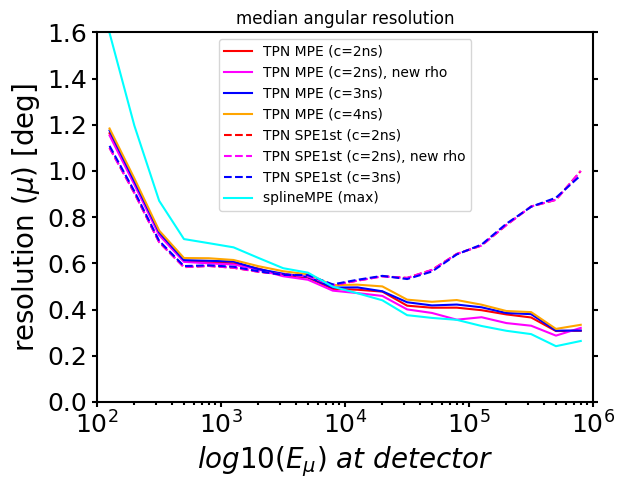

In [38]:
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[0.0, 1.5]}
    
ax.plot(10**xvals, r1_MPE2[1], color='red', label='TPN MPE (c=2ns)')
ax.plot(10**xvals, r1_MPE2_2[1], color='magenta', label='TPN MPE (c=2ns), new rho')
ax.plot(10**xvals, r1_MPE3[1], color='blue', label='TPN MPE (c=3ns)')
ax.plot(10**xvals, r1_MPE4[1], color='orange', label='TPN MPE (c=4ns)')
ax.plot(10**xvals, r1_SPE2[1], color='red', label='TPN SPE1st (c=2ns)', linestyle='dashed')
ax.plot(10**xvals, r1_SPE2_2[1], color='magenta', label='TPN SPE1st (c=2ns), new rho', linestyle='dashed')
ax.plot(10**xvals, r1_SPE3[1], color='blue', label='TPN SPE1st (c=3ns)', linestyle='dashed')
ax.plot(10**xvals, r2_smpe[1], color='cyan', label='splineMPE (max)')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.xscale('log')
plt.title('median angular resolution')
ax.set_yticks([0.2*i for i in range(9)])
plt.show()

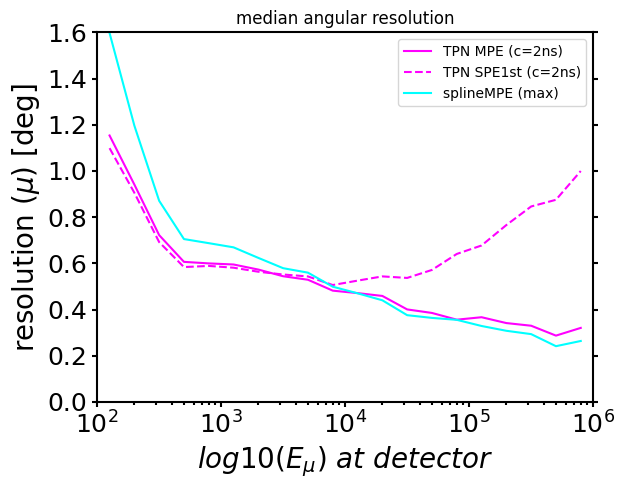

In [39]:
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[0.0, 1.5]}
    
#ax.plot(10**xvals, r1_MPE2[1], color='red', label='TPN MPE (c=2ns)')
ax.plot(10**xvals, r1_MPE2_2[1], color='magenta', label='TPN MPE (c=2ns)')
#ax.plot(10**xvals, r1_MPE3[1], color='blue', label='TPN MPE (c=3ns)')
#ax.plot(10**xvals, r1_MPE4[1], color='orange', label='TPN MPE (c=4ns)')
#ax.plot(10**xvals, r1_SPE2[1], color='red', label='TPN SPE1st (c=2ns)', linestyle='dashed')
ax.plot(10**xvals, r1_SPE2_2[1], color='magenta', label='TPN SPE1st (c=2ns)', linestyle='dashed')
#ax.plot(10**xvals, r1_SPE3[1], color='blue', label='TPN SPE1st (c=3ns)', linestyle='dashed')
ax.plot(10**xvals, r2_smpe[1], color='cyan', label='splineMPE (max)')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.xscale('log')
plt.title('median angular resolution')
ax.set_yticks([0.2*i for i in range(9)])
plt.show()

In [12]:
def get_hist(results, emin, emax):
    gcd, gcd_smpe, muon_energy = get_gcd(results)
    idx = np.logical_and(muon_energy > emin, muon_energy < emax)
    bins = np.linspace(0.0, 3.0, 41)
    cts, _ = np.histogram(gcd[idx], bins=bins)
    cts_smpe, _ = np.histogram(gcd_smpe[idx], bins=bins)
    return cts, bins, cts_smpe


In [13]:
def make_hist_plot(emin, emax):
    cts_MPE2, bins, cts_smpe = get_hist(MPE_sigma2, emin, emax)
    cts_MPE3, bins, cts_smpe = get_hist(MPE_sigma3, emin, emax)
    cts_MPE4, bins, cts_smpe = get_hist(MPE_sigma4, emin, emax)
    cts_SPE2, bins, cts_smpe = get_hist(SPE_sigma2, emin, emax)
    cts_SPE3, bins, cts_smpe = get_hist(SPE_sigma3, emin, emax)

    plot_args = {'xlabel':'angular separation [deg]', 
                 'ylabel':'NEvents', 
                 'xlim':[0.0, 3.0], 
                 'ylim':[0.0, np.amax([cts_smpe, cts_MPE2, cts_MPE3, cts_SPE2, cts_SPE3])*1.1]}
    
    fig, ax = plt.subplots()
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_MPE2, histtype='step', 
             label='TPN MPE (c=2ns)', color='red')
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_MPE3, histtype='step', 
             label='TPN MPE (c=3ns)', color='blue')
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_MPE3, histtype='step', 
             label='TPN MPE (c=4ns)', color='orange')
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_SPE2, histtype='step', color='red', 
             label='TPN SPE1st (c=2ns)', linestyle='dashed')
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_SPE3, histtype='step', color='blue', 
             label='TPN SPE1st (c=3ns)', linestyle='dashed')
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_smpe, histtype='step', color='cyan', 
             label='splineMPE (max)')
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.title(f"muon energy: {emin/1000}TeV to {emax/1000}TeV")
    plt.show()

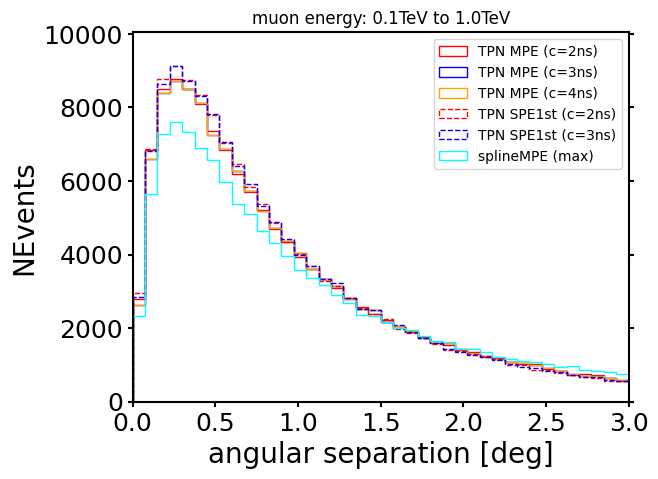

In [14]:
make_hist_plot(100, 1000)

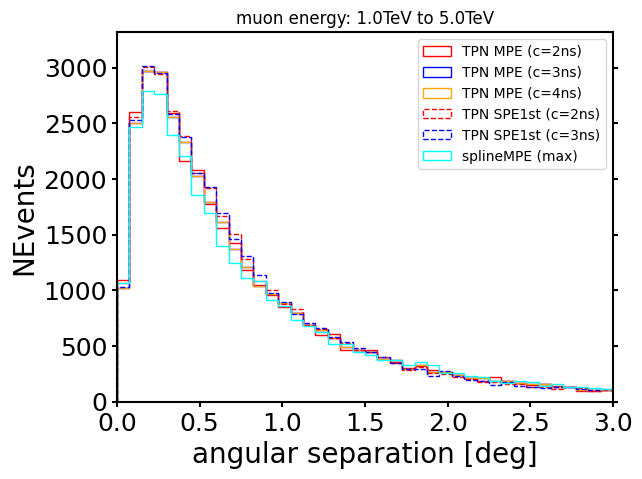

In [15]:
make_hist_plot(1000, 5000)

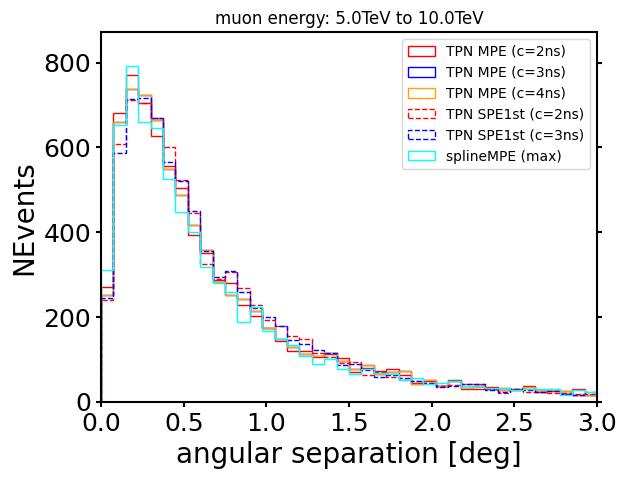

In [16]:
make_hist_plot(5000, 10000)

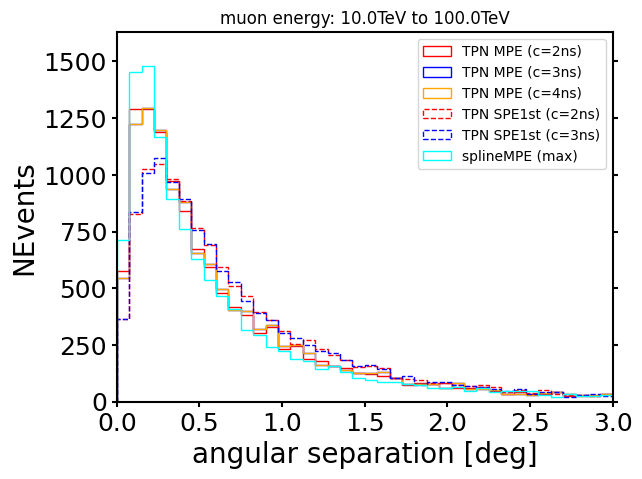

In [17]:
make_hist_plot(10000, 100000)

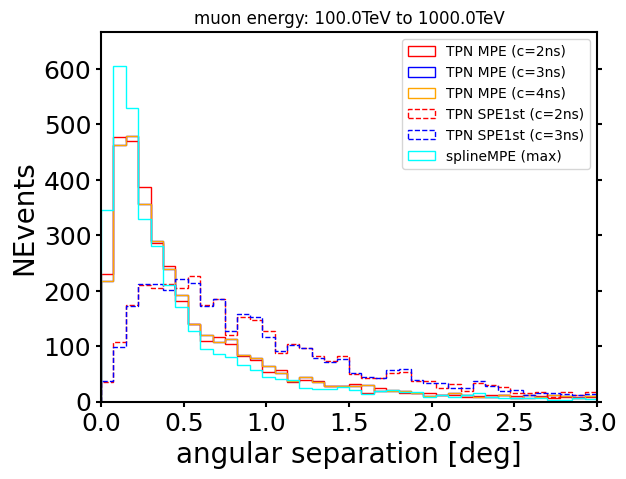

In [18]:
make_hist_plot(100000, 1000000)

In [19]:
muon_energy, delta_logl = get_deltalogl(MPE_sigma2_rho)

In [20]:
np.percentile(delta_logl, [68, 90])

array([10.19727261, 17.85676132])

In [21]:
from scipy.stats import chi2

In [22]:
chi2.cdf(14, 5)

0.9843905838997331

In [23]:
def make_hist_plot_logl(results, emin, emax, nbins = 156, xmax=150):
    def get_hist(results, emin, emax):
        muon_energy, delta_logl = get_deltalogl(results)
        idx = np.logical_and(muon_energy > emin, muon_energy < emax)
        bins = np.linspace(-5.0, 150.0, nbins)
        cts, _ = np.histogram(delta_logl[idx], bins=bins)
        return cts, bins
    
    cts, bins = get_hist(MPE_sigma2_rho, emin, emax)

    plot_args = {'xlabel':'-2$\Delta$logL', 
                 'ylabel':'NEvents', 
                 'xlim':[-2.0, xmax], 
                 'ylim':[0.0, 1.2*np.amax(cts)]}
    
    fig, ax = plt.subplots()
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts, histtype='step', 
             label='TPN MPE (c=2ns)', color='red')
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.title(f"muon energy: {emin/1000}TeV to {emax/1000}TeV")
    plt.yscale('log')
    plt.ylim(ymin=1.e-1)
    plt.show()

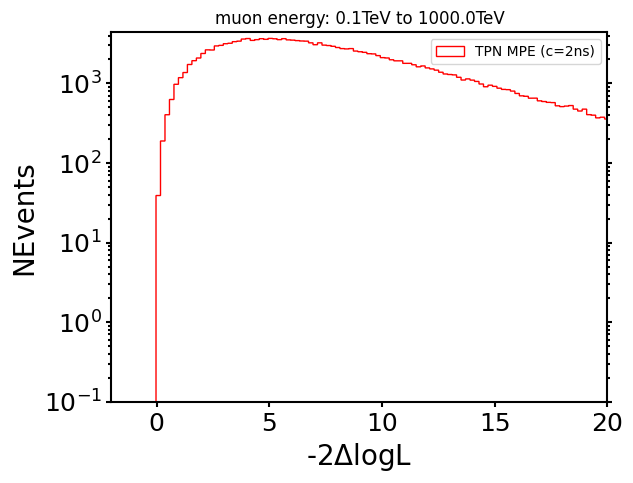

In [24]:
make_hist_plot_logl(MPE_sigma2_rho, 100, 1000000, nbins=156*5, xmax=20)

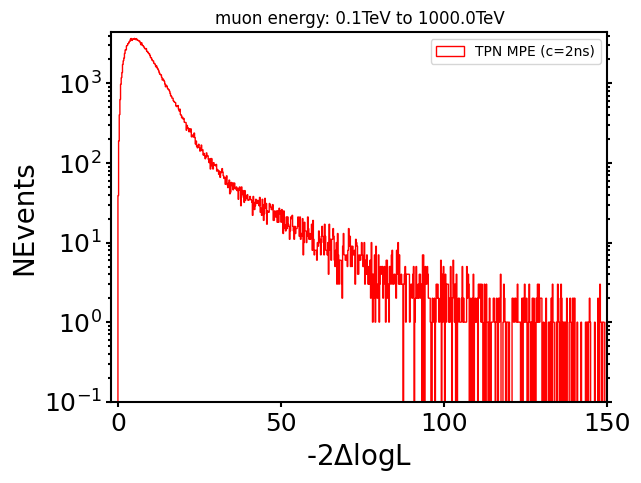

In [25]:
make_hist_plot_logl(MPE_sigma2_rho, 100, 1000000, nbins=156*5)

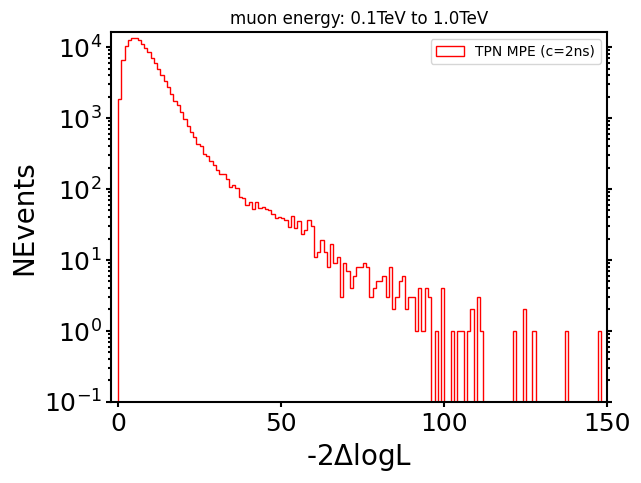

In [26]:
make_hist_plot_logl(MPE_sigma2_rho, 100, 1000)

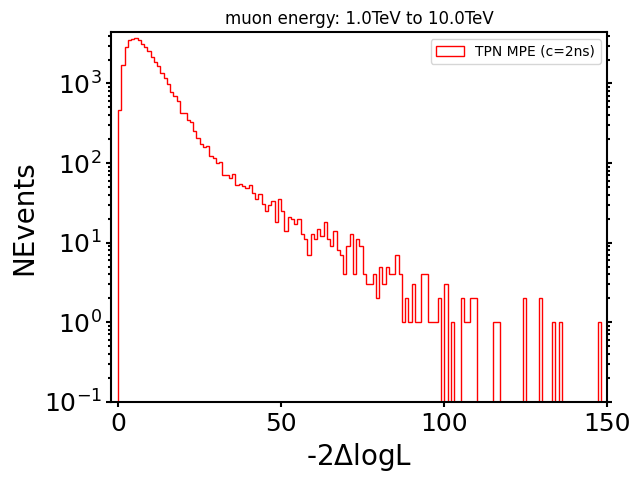

In [27]:
make_hist_plot_logl(MPE_sigma2_rho, 1000, 10000)

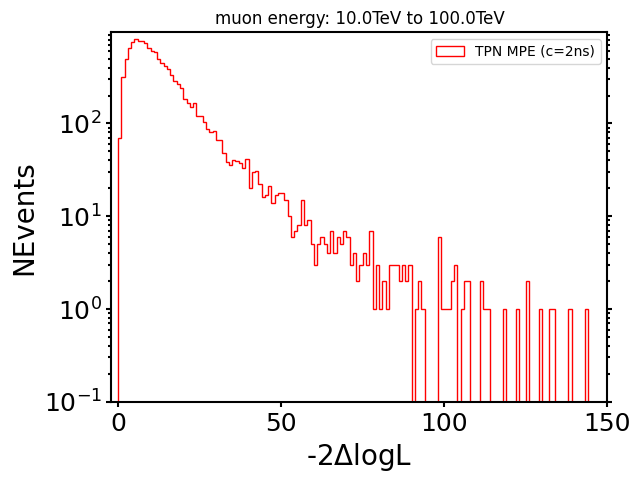

In [28]:
make_hist_plot_logl(MPE_sigma2_rho, 10000, 100000)

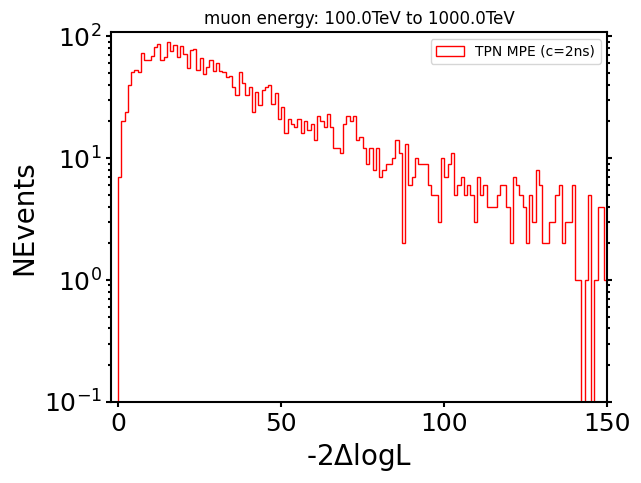

In [29]:
make_hist_plot_logl(MPE_sigma2_rho, 100000, 1000000)